# MRI maps

Goal: Correlate PCs with HCP maps from Jakob

In [1]:
# Import modules and R
import numpy as np, pandas as pd
from plotnine import *
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append('../code')
import pcaVersion
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");

/opt/conda/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
Attaching package: ‘lemon’



    %||%



    CoordCartesian, element_render




Get maps

In [3]:
maps = get_maps()

Get PCs

In [53]:
data_dir = "~/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/abagen-data/expression/"
# hcp_base = pcaVersion(pd.read_csv(data_dir + 'hcp_base.csv', index_col=0))
# hcp_3donors_ds7 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds7.csv', index_col=0))
# hcp_3donors_ds8 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds8.csv', index_col=0))
hcp_3donors_ds9 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds9.csv', index_col=0))
scores = hcp_base.score_from(hcp_3donors_ds9).iloc[:,:3].apply(lambda x: (x-np.mean(x))/np.std(x)).rename_axis('region')

New PCA version


Check correlations

In [54]:
corrs = get_corrs(scores, maps, method='pearson')
corrs.style.format('{:.2f}')

,PC1,PC2,PC3
Myelination (T1w/T2w ratio),0.71,-0.17,0.28
Cortical Thickness,-0.64,0.16,-0.00
Intracortical Connectivity Distance,0.10,-0.60,0.15
Size Variation (allometric scaling),0.25,0.18,-0.33
Cerebral Blood Flow,0.18,0.25,-0.36
Glucose Metabolic Rate (CMRGlu),0.58,0.43,-0.44
Oxygen Metabolic Rate (CMRO2),0.68,0.15,-0.21
Glycolytic Index (CMRO2/CMRGlu),0.17,0.60,-0.54
fMRI PC1,-0.42,0.16,-0.41
NeuroSynth PC1,-0.22,-0.33,-0.12


Generate null spins/sims, or just load them, and calculate correlations with the nulls

In [55]:
# null_corrs_dict = {}
# null_corrs_dict_ds8 = null_corrs_dict
# null_corrs_dict_ds7 = null_corrs_dict
null_corrs_dict = {}

In [56]:
# generate_spins(maps, 1000, '../outputs/spin_maps_v2_1000.npy')
ix_keep = [i for i in range(15) if i not in (4,9,14)]
spin_maps_1000 = np.load("../outputs/spin_maps_v2_1000.npy")[:,ix_keep,:]
null_corrs_dict['spin_maps_p'] = corr_nulls_from_maps(spin_maps_1000, scores, maps, method='pearson')
# null_corrs_dict['spin_maps_s'] = corr_nulls_from_maps(spin_maps_1000, scores, maps, method='spearman')

In [57]:
# generate_surrogates(maps, 1000, '../outputs/sim_maps_v2_1000.npy')
ix_keep = [i for i in range(15) if i not in (4,9,14)]
sim_maps_1000 = np.load("../outputs/sim_maps_v2_1000.npy")[:,ix_keep,:]
null_corrs_dict['sim_maps_p'] = corr_nulls_from_maps(sim_maps_1000, scores, maps, method='pearson')
# null_corrs_dict['sim_maps_s'] = corr_nulls_from_maps(sim_maps_1000, scores, maps, method='spearman')

In [58]:
# Match distance matrix to PC parcels and generate surrogates
dist_mat = np.loadtxt("../data/LeftParcelGeodesicDistmat.txt")
inds = [i-1 for i in scores.index]
dist_mat_matched = dist_mat[inds,:][:,inds]
np.savetxt("../data/LeftParcelGeodesicDistmat_PCmatched.txt", dist_mat_matched)

In [126]:
# generate_surrogates(scores, 1000, 
#                     dist_mat="../data/LeftParcelGeodesicDistmat_PCmatched.txt",
#                     outfile="../outputs/sim_pcs_1000.npy")
# generate_spins_from_pcs(scores, 1000, outfile='../outputs/spin_pcs_1000.npy')

In [59]:
spin_pcs_1000 = np.load("../outputs/spin_pcs_1000.npy")
null_corrs_dict['spin_pcs_p'] = corr_nulls_from_pcs(spin_pcs_1000, scores, maps, method='pearson')
# null_corrs_dict['spin_pcs_s'] = corr_nulls_from_pcs(spin_pcs_1000, scores, maps, method='spearman')

In [60]:
sim_pcs_1000 = np.load("../outputs/sim_pcs_1000.npy")
null_corrs_dict['sim_pcs_p'] = corr_nulls_from_pcs(sim_pcs_1000, scores, maps, method='pearson')
# null_corrs_dict['sim_pcs_s'] = corr_nulls_from_pcs(sim_pcs_1000, scores, maps, method='spearman')

In [65]:
# corrs = get_corrs(scores, maps, method='pearson')
null_corrs = null_corrs_dict['sim_maps_p']
null_p = get_null_p(corrs, null_corrs)

In [66]:
print_corrs_sig(corrs, null_p)

,PC1,PC2,PC3
Myelination (T1w/T2w ratio),0.71 ***,-0.17,0.28 *
Cortical Thickness,-0.64 ***,0.16,-0.0
Intracortical Connectivity Distance,0.1,-0.6 *,0.15
Size Variation (allometric scaling),0.25,0.18,-0.33 **
Cerebral Blood Flow,0.18,0.25,-0.36 **
Glucose Metabolic Rate (CMRGlu),0.58 *,0.43,-0.44 ***
Oxygen Metabolic Rate (CMRO2),0.68 ***,0.15,-0.21
Glycolytic Index (CMRO2/CMRGlu),0.17,0.6 *,-0.54 ***
fMRI PC1,-0.42,0.16,-0.41 ***
NeuroSynth PC1,-0.22,-0.33,-0.12


In [63]:
scores_plot = scores.join(get_labels_hcp())

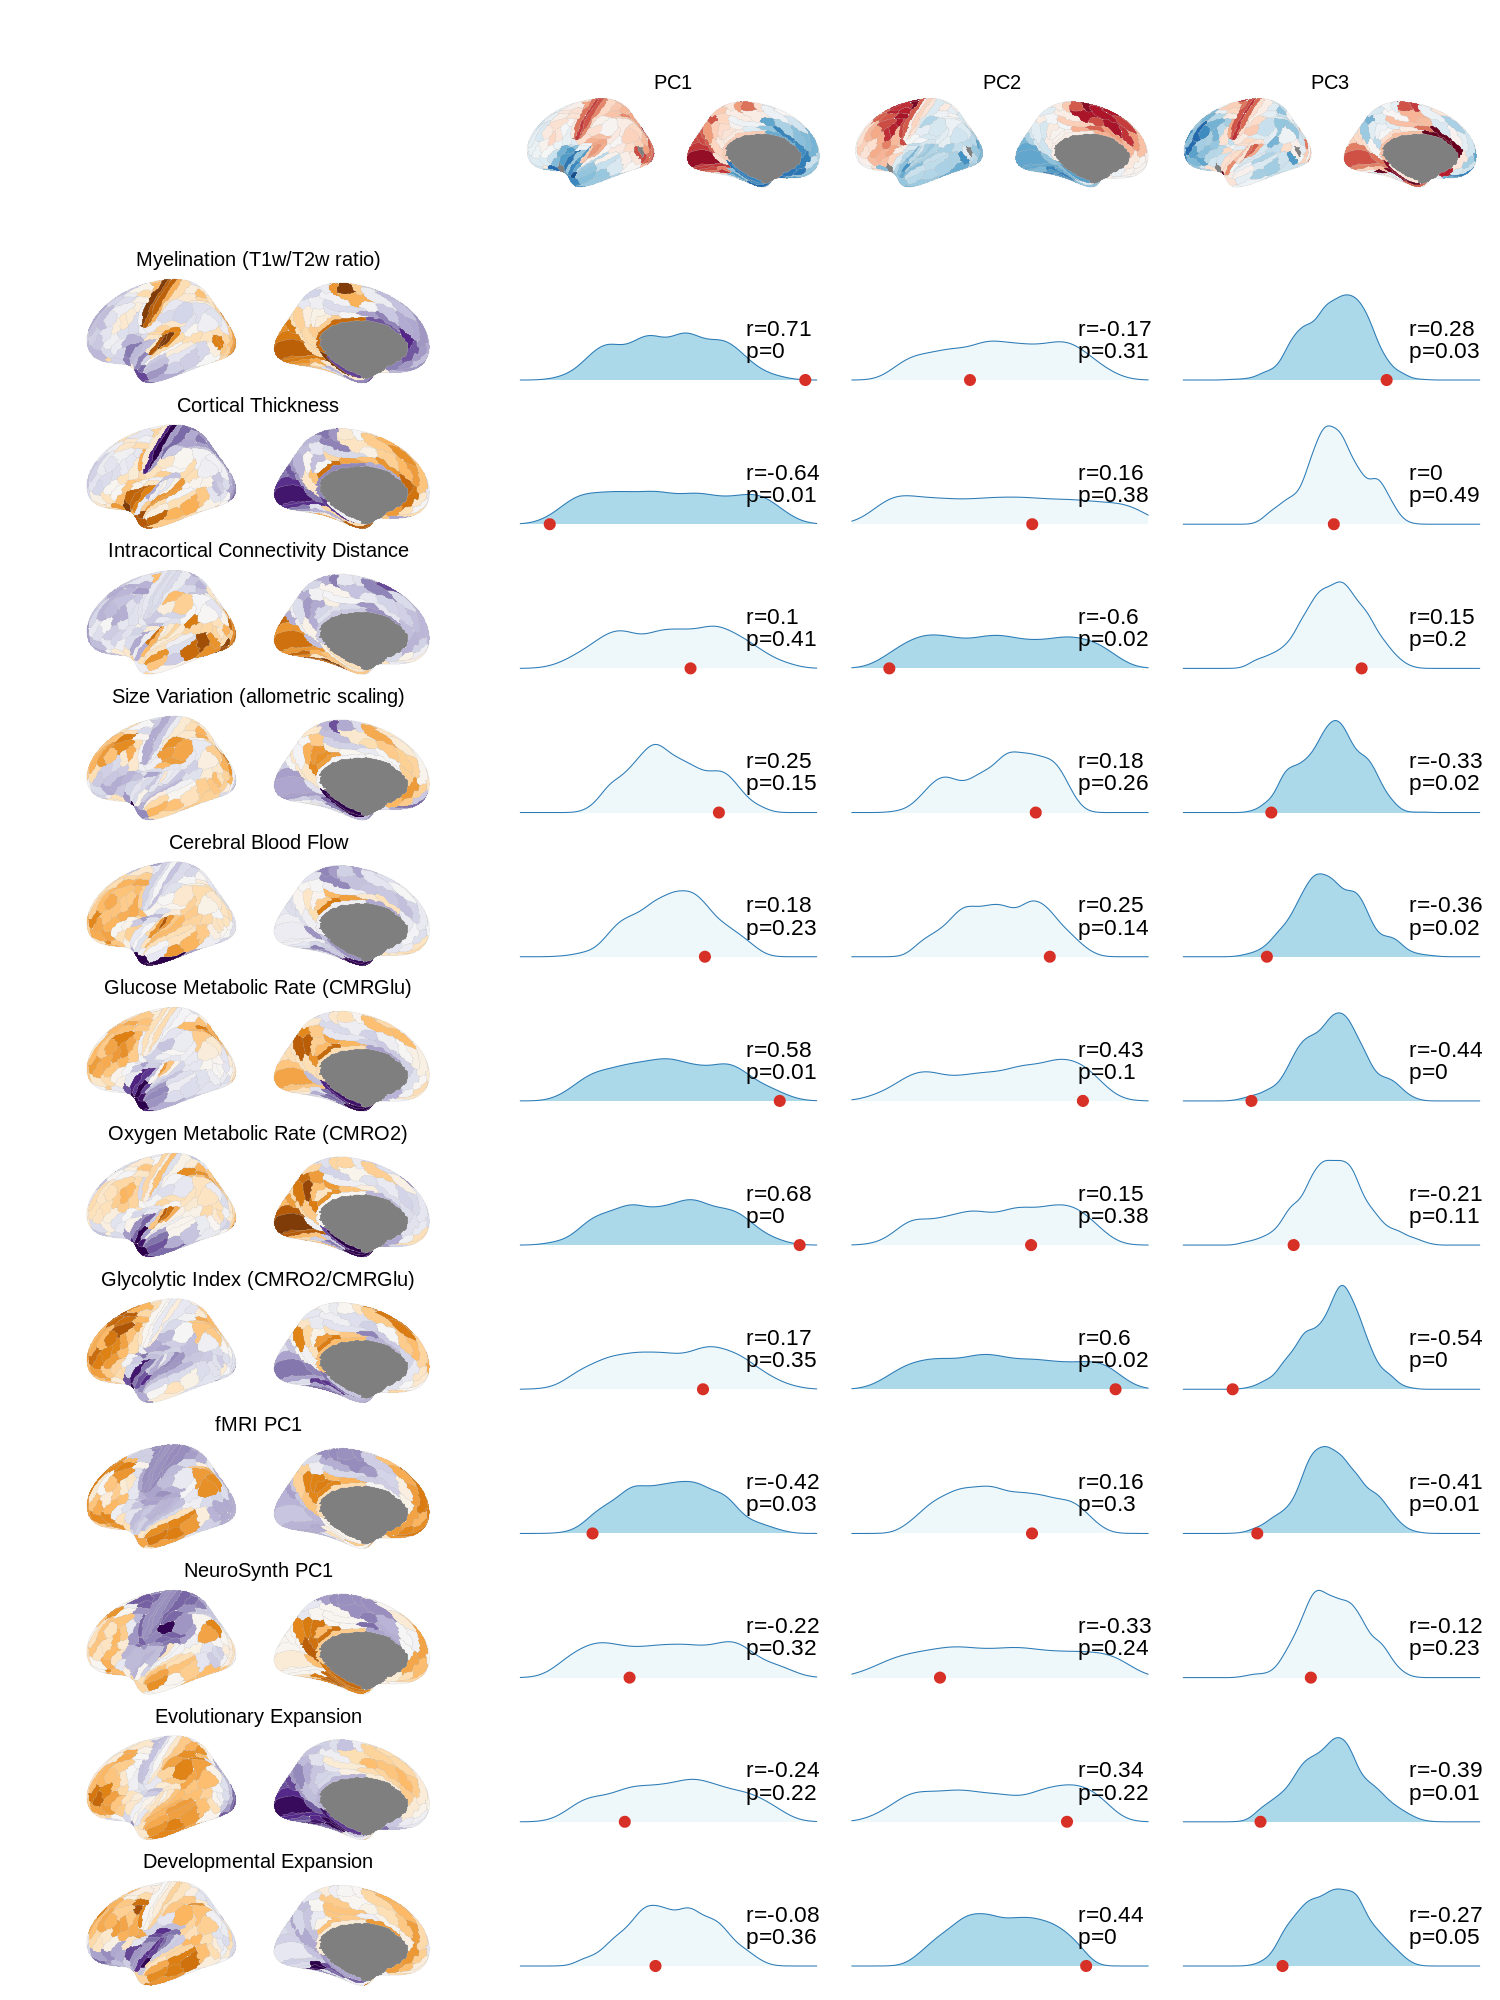

In [64]:
%%R -i corrs -i null_corrs -i null_p -i scores_plot -i maps -w 1500 -h 2000
source("../code/plot_maps.R")
source("../code/brainPlots.R")
g1 <- plot_null_corrs(corrs, null_corrs, null_p)
g2 <- plot_hcp_wide(scores_plot, spacing=0) + guides(fill='none')
g3 <- plot_maps(maps, colors=rev(brewer.puor(100)), ncol=1) + guides(fill='none')

(
    ((plot_spacer() | g2) + plot_layout(widths=c(1,2))) / 
    ((g3 | g1) + plot_layout(widths=c(1,2)))
) + plot_layout(heights=c(1.2,12))

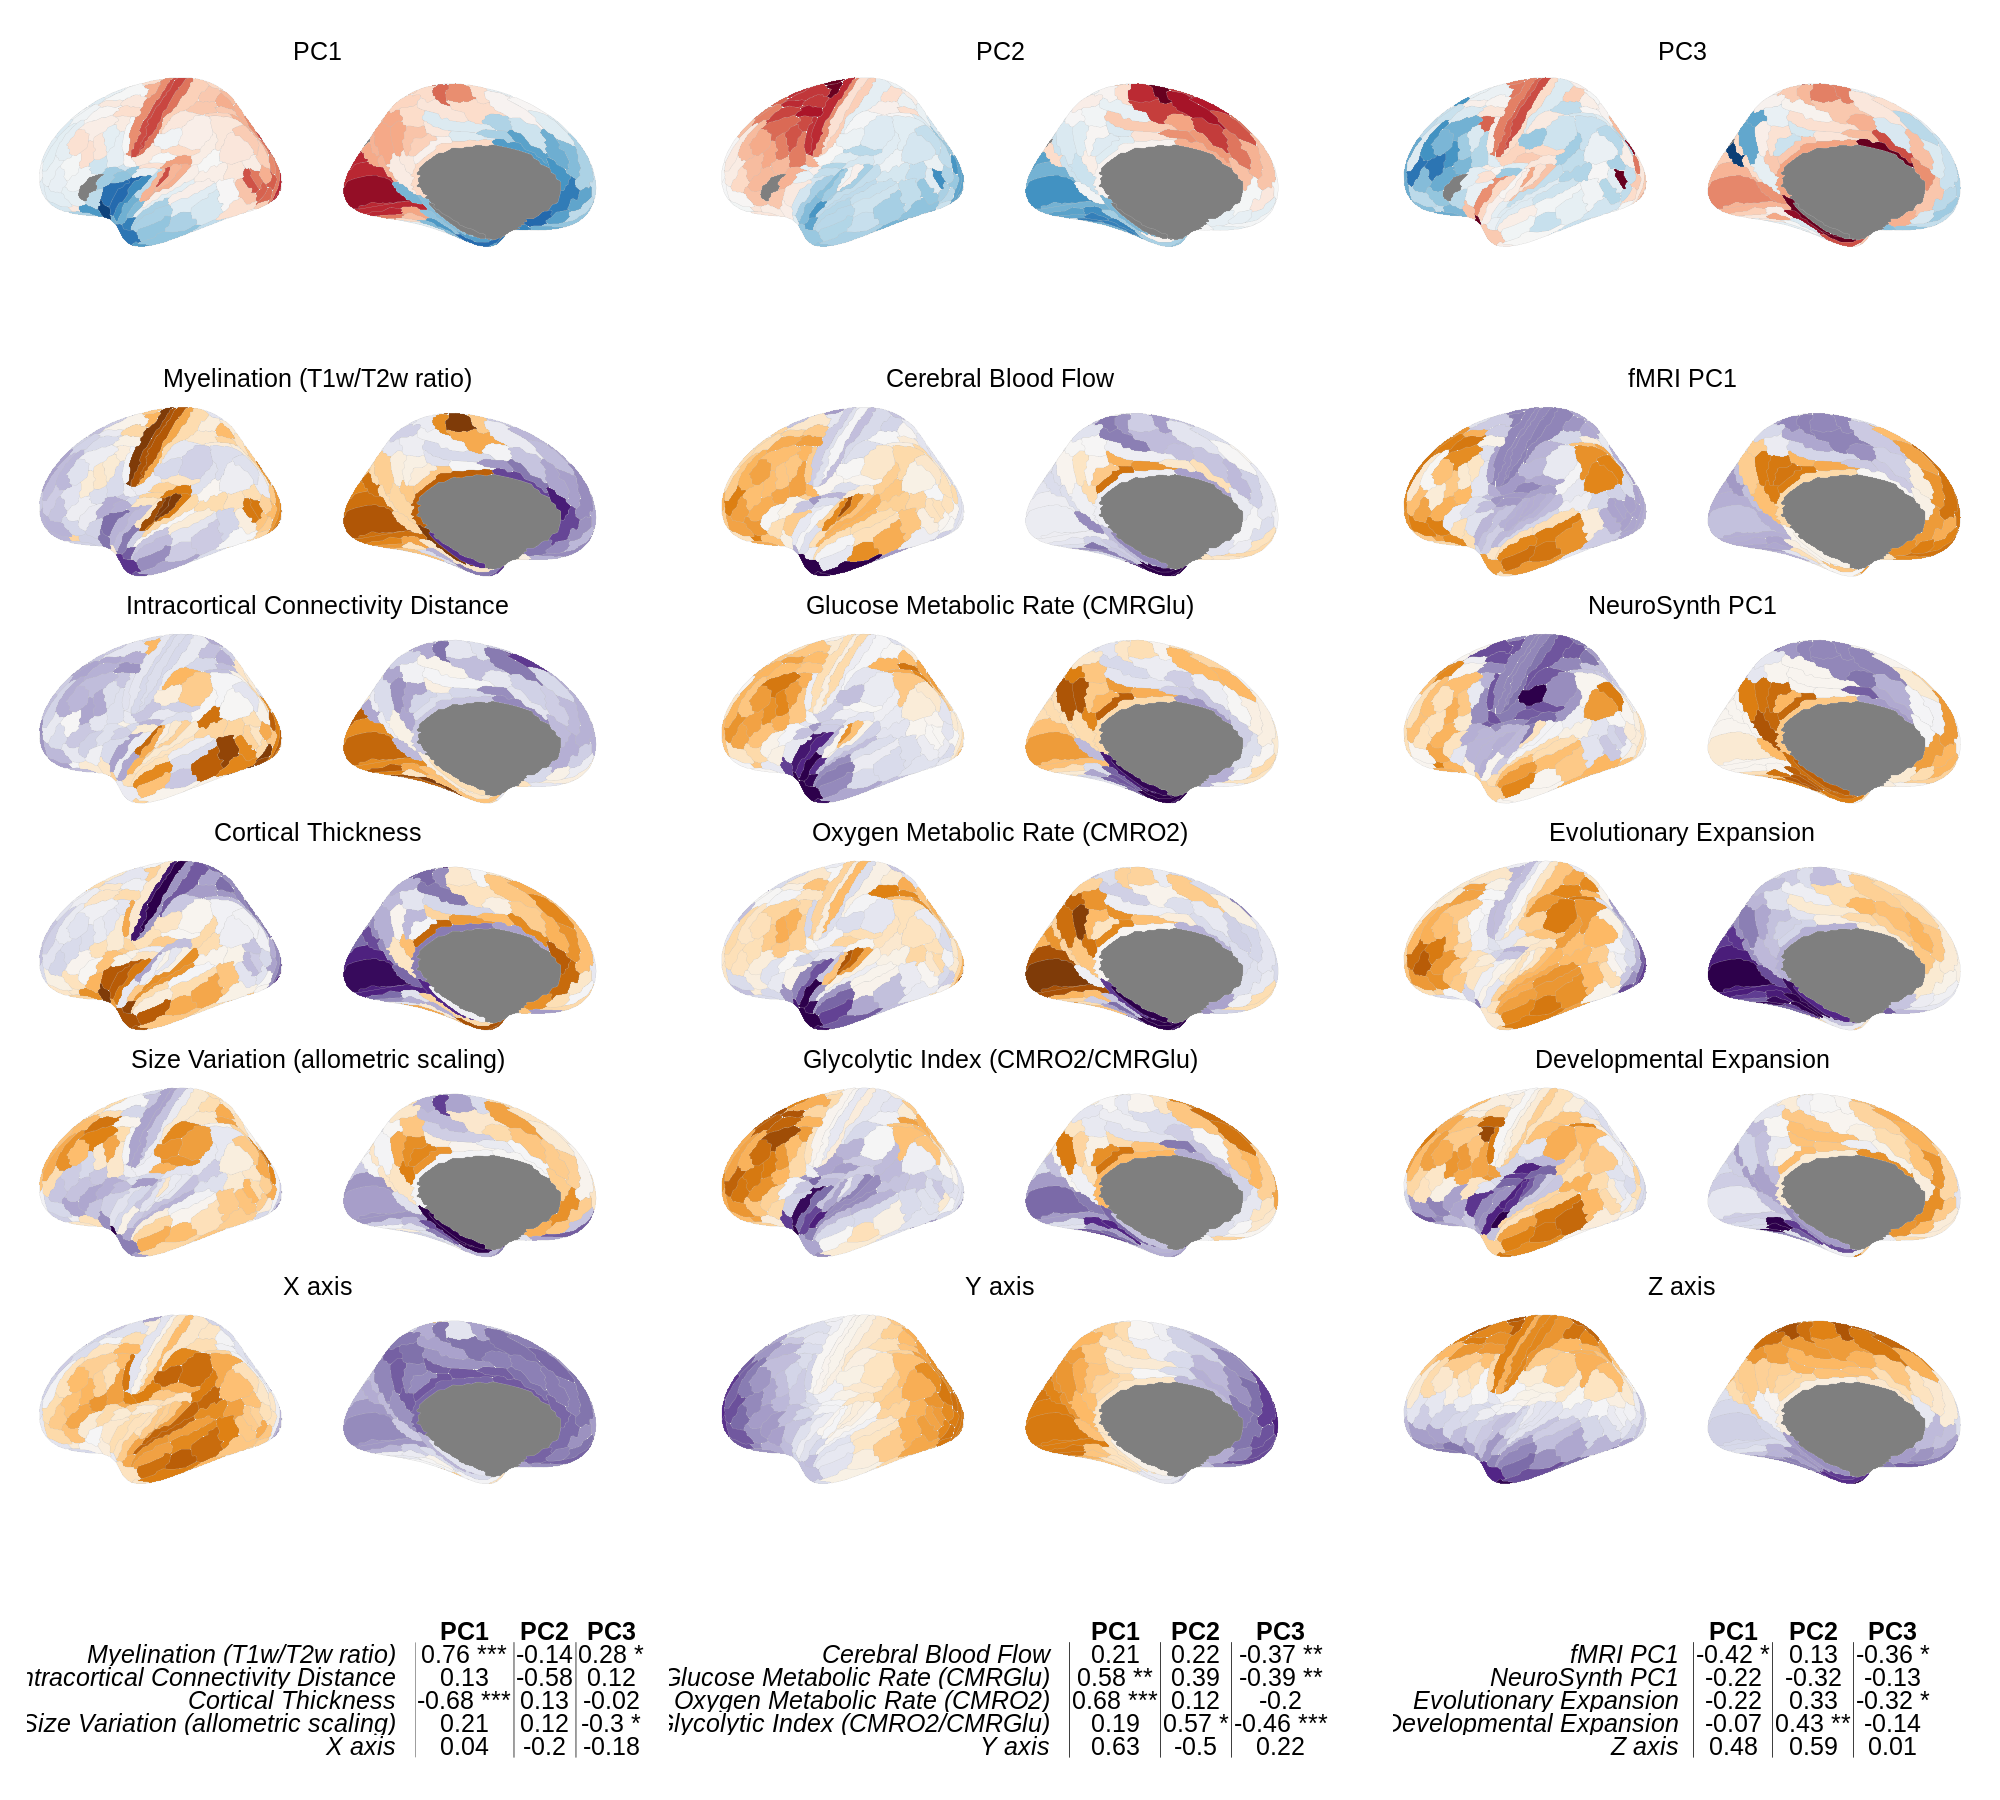

In [615]:
%%R -w 2000 -h 1800 -i maps_plot -i scores_plot -i map_corrs_sig
library(ggpubr)
g2 <- plot_hcp_wide(scores_plot) + guides(fill='none') + theme(strip.text.x = element_text(size=25))
g3 <- plot_maps(maps_plot, colors=rev(brewer.puor(100))) + guides(fill='none') + theme(strip.text.x = element_text(size=25))
gt1 <- ggtexttable(map_corrs_sig[1:5,], theme=ttheme('minimal', base_size=25, padding = unit(c(5, 5, 5, 5), "pt")))
gt2 <- ggtexttable(map_corrs_sig[6:10,], theme=ttheme('minimal', base_size=25, padding = unit(c(5, 5, 5, 5), "pt")))
gt3 <- ggtexttable(map_corrs_sig[11:15,], theme=ttheme('minimal', base_size=25, padding = unit(c(5, 5, 5, 5), "pt")))

(g2 / g3 / (gt1 | gt2 | gt3)) + plot_layout(heights=c(1,6,1))

In [90]:
%%R -i null_corrs

# null_corrs$PC1 %>% density %>%

null_corrs <- null_corrs %>% gather(PC, corr, -map)

density_list <- null_corrs %>% group_by(PC, map) %>% group_map(~ density(.$corr))
density_groups <- null_corrs %>% unique(PC, map)

get_density_df <- function(density, PC) {
    density_df <- data.frame(x=density$x, y=density$y) %>% 
            mutate(q = ifelse(y < quantile(.$y, .05), 'lo', ifelse(y > quantile(.$y, .95), 'hi', 'mid'))) %>% 
            mutate(PC = PC)
    return(density_df)
}

for 

density_df <- rbind(
    get_density_df(density_list[[1]], 'PC1'),
    get_density_df(density_list[[2]], 'PC2'),
    get_density_df(density_list[[3]], 'PC3')
)
density_df %>% head

# ggplot() + 
#     facet_grid(factor(map, levels=unique(null_corrs$map))~pc, switch='y') +
#     geom_density(aes(corr), color=mycolors[5]) +
#     theme_minimal() +
#     theme(
#           strip.text.y.left = element_blank(),
#           panel.grid = element_blank(),
#           axis.text.y = element_blank(),
#           text = element_text(size=30)
#          )
    

           x            y  q  PC
1 -0.8415793 5.655989e-05 lo PC1
2 -0.8382415 7.350975e-05 lo PC1
3 -0.8349037 9.479246e-05 lo PC1
4 -0.8315659 1.213021e-04 lo PC1
5 -0.8282281 1.540666e-04 lo PC1
6 -0.8248903 1.942581e-04 lo PC1


---

---

In [508]:
selected_maps = {
    #PC1
    'thickness':'Thickness',
    'T1T2':'Myelination (T1w/T2w ratio)',
    'glasser_CMRO2':'Oxygen Metabolic Rate (CMRO2)',
    #PC2
    'hill.dev_remapped':'Developmental Expansion',
    'externopyramidisation':'Intracortical Connectivity Distance',
    'glasser_GI':'Glycolytic Index (CMRO2/CMRGlu)',
    #PC3
    'allom':'Size Variation (allometric scaling)',
    'CBF':'Cerebral Blood Flow',
    'glasser_CMRGlu':'Glucose Metabolic Rate (CMRGlu)',
    #axes
    'x':'X axis',
    'y':'Y axis',
    'z':'Z axis'
}

# maps = maps_jakob.loc[:, list(selected_maps.keys())]
maps = maps_jakob
maps

,CBF,G1_fMRI,PC1_AHBA,PC1_neurosynth,T1T2,allom,asl,curvature,externopyramidisation,geodist,...,glasser_CBV,glasser_CMRGlu,glasser_CMRO2,glasser_GI,hill.dev_remapped,hill.evo_remapped,thickness,x,y,z
region,,,,,,,,,,,,,,,,,,,,,
V1,-0.179597,-0.750526,-2.359875,0.261369,1.977036,-1.085134,-0.085518,1.555901,1.769126,-1.975811,...,2.293495,1.231160,2.873226,-1.523300,-0.275131,-2.446501,-2.310289,-1.255505,1.560962,-0.583163
MST,0.415531,-1.042511,-0.667729,-0.536989,1.575121,0.965346,0.263112,-0.905143,0.630473,-0.100868,...,-0.273515,0.017804,0.318382,-0.392062,0.246052,0.067569,-0.815568,0.738100,1.155091,-0.203728
V6,-0.433862,-1.135492,-1.890494,0.056781,1.647248,-0.020746,-0.355929,-0.366673,-1.006875,-1.563375,...,0.445668,0.515730,1.291453,-0.755553,-0.610757,-1.870358,-1.721457,-0.966524,1.438821,0.519752
V2,-0.156811,-0.933047,-2.073466,0.056781,1.665496,-1.157744,-0.267413,1.427644,1.377546,-1.930489,...,2.718926,0.871595,2.060033,-1.113092,-0.614974,-2.070317,-2.030079,-1.142430,1.510433,-0.497031
V3,-0.268078,-0.953694,-1.969166,0.056781,1.430449,-0.624528,-0.302699,1.207608,1.888340,-1.902737,...,1.801476,0.480104,0.991689,-0.421922,-0.479010,-1.813154,-1.497054,-0.879968,1.576216,-0.374542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STSva,-0.064344,1.434124,0.899926,1.234535,-0.795757,0.609727,0.071231,-1.014288,1.400205,0.778556,...,-0.442127,-1.356592,-1.549051,-0.482769,1.170922,1.189967,0.205376,1.176556,-0.238875,-1.290717
TE1m,1.361941,1.611986,0.713989,0.056781,-0.634758,0.906969,0.899422,1.246423,-0.677230,0.405919,...,-0.185135,-0.469423,-1.006154,0.461361,1.626480,1.581797,1.084687,1.884027,0.182489,-1.208325
PI,-0.387085,-0.607650,1.448596,0.056781,-1.391843,0.118060,-0.586942,-3.391453,-1.012710,0.297004,...,2.077343,-2.885445,-2.744273,-1.762716,-2.009474,-0.268852,-0.240927,0.744796,-0.359852,-1.148027


In [511]:
data_dir = "~/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/abagen-data/expression/"
hcp_base = pcaVersion(pd.read_csv(data_dir + 'hcp_base.csv', index_col=0))
# hcp_3donors = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors.csv', index_col=0))
# hcp_3donors_ds7 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds7.csv', index_col=0))
hcp_3donors_ds8 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds8.csv', index_col=0))
# hcp_3donors_ds9 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds9.csv', index_col=0))

New PCA version
New PCA version


Get correlations

In [512]:
version = hcp_3donors_ds8
scores = hcp_base.score_from(hcp_3donors_ds8).iloc[:,:3].apply(lambda x: (x-np.mean(x))/np.std(x))

corrs = get_corrs(scores, maps, method='spearman')
corrs.style.format('{:.2f}')

,PC1,PC2,PC3
T1T2,0.78,0.22,0.24
externopyramidisation,0.13,0.62,-0.13
thickness,-0.64,-0.13,-0.04
G1_fMRI,-0.48,-0.22,-0.28
hill.evo_remapped,-0.28,-0.34,-0.17
allom,0.17,-0.15,-0.01
CBF,0.03,-0.34,-0.23
PC1_neurosynth,-0.22,0.26,-0.29
hill.dev_remapped,-0.16,-0.44,0.05
glasser_CMRGlu,0.49,-0.51,0.01


In [338]:
null_corrs = {}

Random shuffles?

In [339]:
generate_shuffles(maps)
shuffle_maps = np.load("../outputs/shuffle_maps_1000.npy")

null_corrs_dict['shuffle'] = corr_nulls_from_maps(shuffle_maps, scores, maps)

Spins

In [ ]:
spin_maps_1000 = np.load("../outputs/spin_maps_1000.npy")
map_inds = maps_jakob.columns.get_indexer(maps.columns)
spin_maps = spin_maps_1000[:,map_inds,:]
null_corrs_dict['spin_maps_pe'] = corr_nulls_from_maps(
    spin_maps, scores, maps, method='pearson')

In [ ]:
null_corrs_dict['spin_maps_sp'] = corr_nulls_from_maps(
    spin_maps, scores, maps, method='spearman')

Spin PCs instead?

In [ ]:
spin_pcs_1000 = np.load("../outputs/spin_pcs_1000.npy")
spin_pcs = spin_pcs_1000
null_corrs_dict['spin_pcs_pe'] = corr_nulls_from_pcs(
    spin_pcs, scores, maps, method='pearson')
null_corrs_dict['spin_pcs_sp'] = corr_nulls_from_pcs(
    spin_pcs, scores, maps, method='spearman')

What if we use surrogate brain maps instead of spins?

In [ ]:
generate_surrogates(maps, 1000, '../outputs/sim_maps2_1000.npy')
# sim_maps_1000 = np.load("../outputs/sim_maps_1000.npy")
# null_corrs_dict['sim_maps_pe'] = corr_nulls_from_maps(
#     sim_maps_1000, scores, maps, method='pearson')
# null_corrs_dict['sim_maps_sp'] = corr_nulls_from_maps(
#     sim_maps_1000, scores, maps, method='spearman')

In [140]:
# Match distance matrix to PC parcels and generate surrogates
dist_mat = np.loadtxt("../data/LeftParcelGeodesicDistmat.txt")
inds = [i-1 for i in scores.index]
dist_mat_matched = dist_mat[inds,:][:,inds]
np.savetxt("../data/LeftParcelGeodesicDistmat_PCmatched.txt", dist_mat_matched)

In [ ]:
# generate_surrogates(scores, 1000, 
#                     dist_mat="../data/LeftParcelGeodesicDistmat_PCmatched.txt",
#                     outfile="../outputs/sim_pcs_1000.npy")

In [340]:
sim_pcs_1000 = np.load("../outputs/sim_pcs_1000.npy")
# sim_pcs_1000.shape
null_corrs_dict['sim_pcs_pe'] = corr_nulls_from_pcs(
    sim_pcs_1000, scores, maps, method='pearson')
null_corrs_dict['sim_pcs_sp'] = corr_nulls_from_pcs(
    sim_pcs_1000, scores, maps, method='spearman')

## Analyze!

Get p values and significance

In [503]:
corrs = get_corrs(scores, maps, method='pearson')
null_corrs = null_corrs_dict['spin_maps_pe']
null_p = get_null_p(corrs, null_corrs)

KeyError: 'G1_fMRI'

In [358]:
map_corrs_sig = (corrs
 .loc[null_sig.index]
 .round(2).astype('string')
 .where(null_p > .05, other = lambda x: x+' *')
 .where(null_p > .01, other = lambda x: x+'*')
 .where(null_p > .001, other = lambda x: x+'*')
)
# map_corrs_sig.to_csv("../outputs/map_corrs_sig.csv")
map_corrs_sig

,PC1,PC2,PC3
thickness,-0.66 ***,0.11,0.0
T1T2,0.79 ***,-0.2,0.27
glasser_CMRO2,0.66 ***,0.11,-0.07
hill.dev_remapped,-0.14,0.38 *,-0.13
externopyramidisation,0.12,-0.66 *,0.11
glasser_GI,0.15,0.58 *,-0.43 **
allom,0.17,0.1,-0.12
CBF,0.05,0.22,-0.44 **
glasser_CMRGlu,0.51 *,0.43,-0.29
x,0.04,-0.23,-0.21


In [359]:
maps_order = maps.loc[:, null_sig.index]
scores_plot = scores.join(get_labels_hcp())

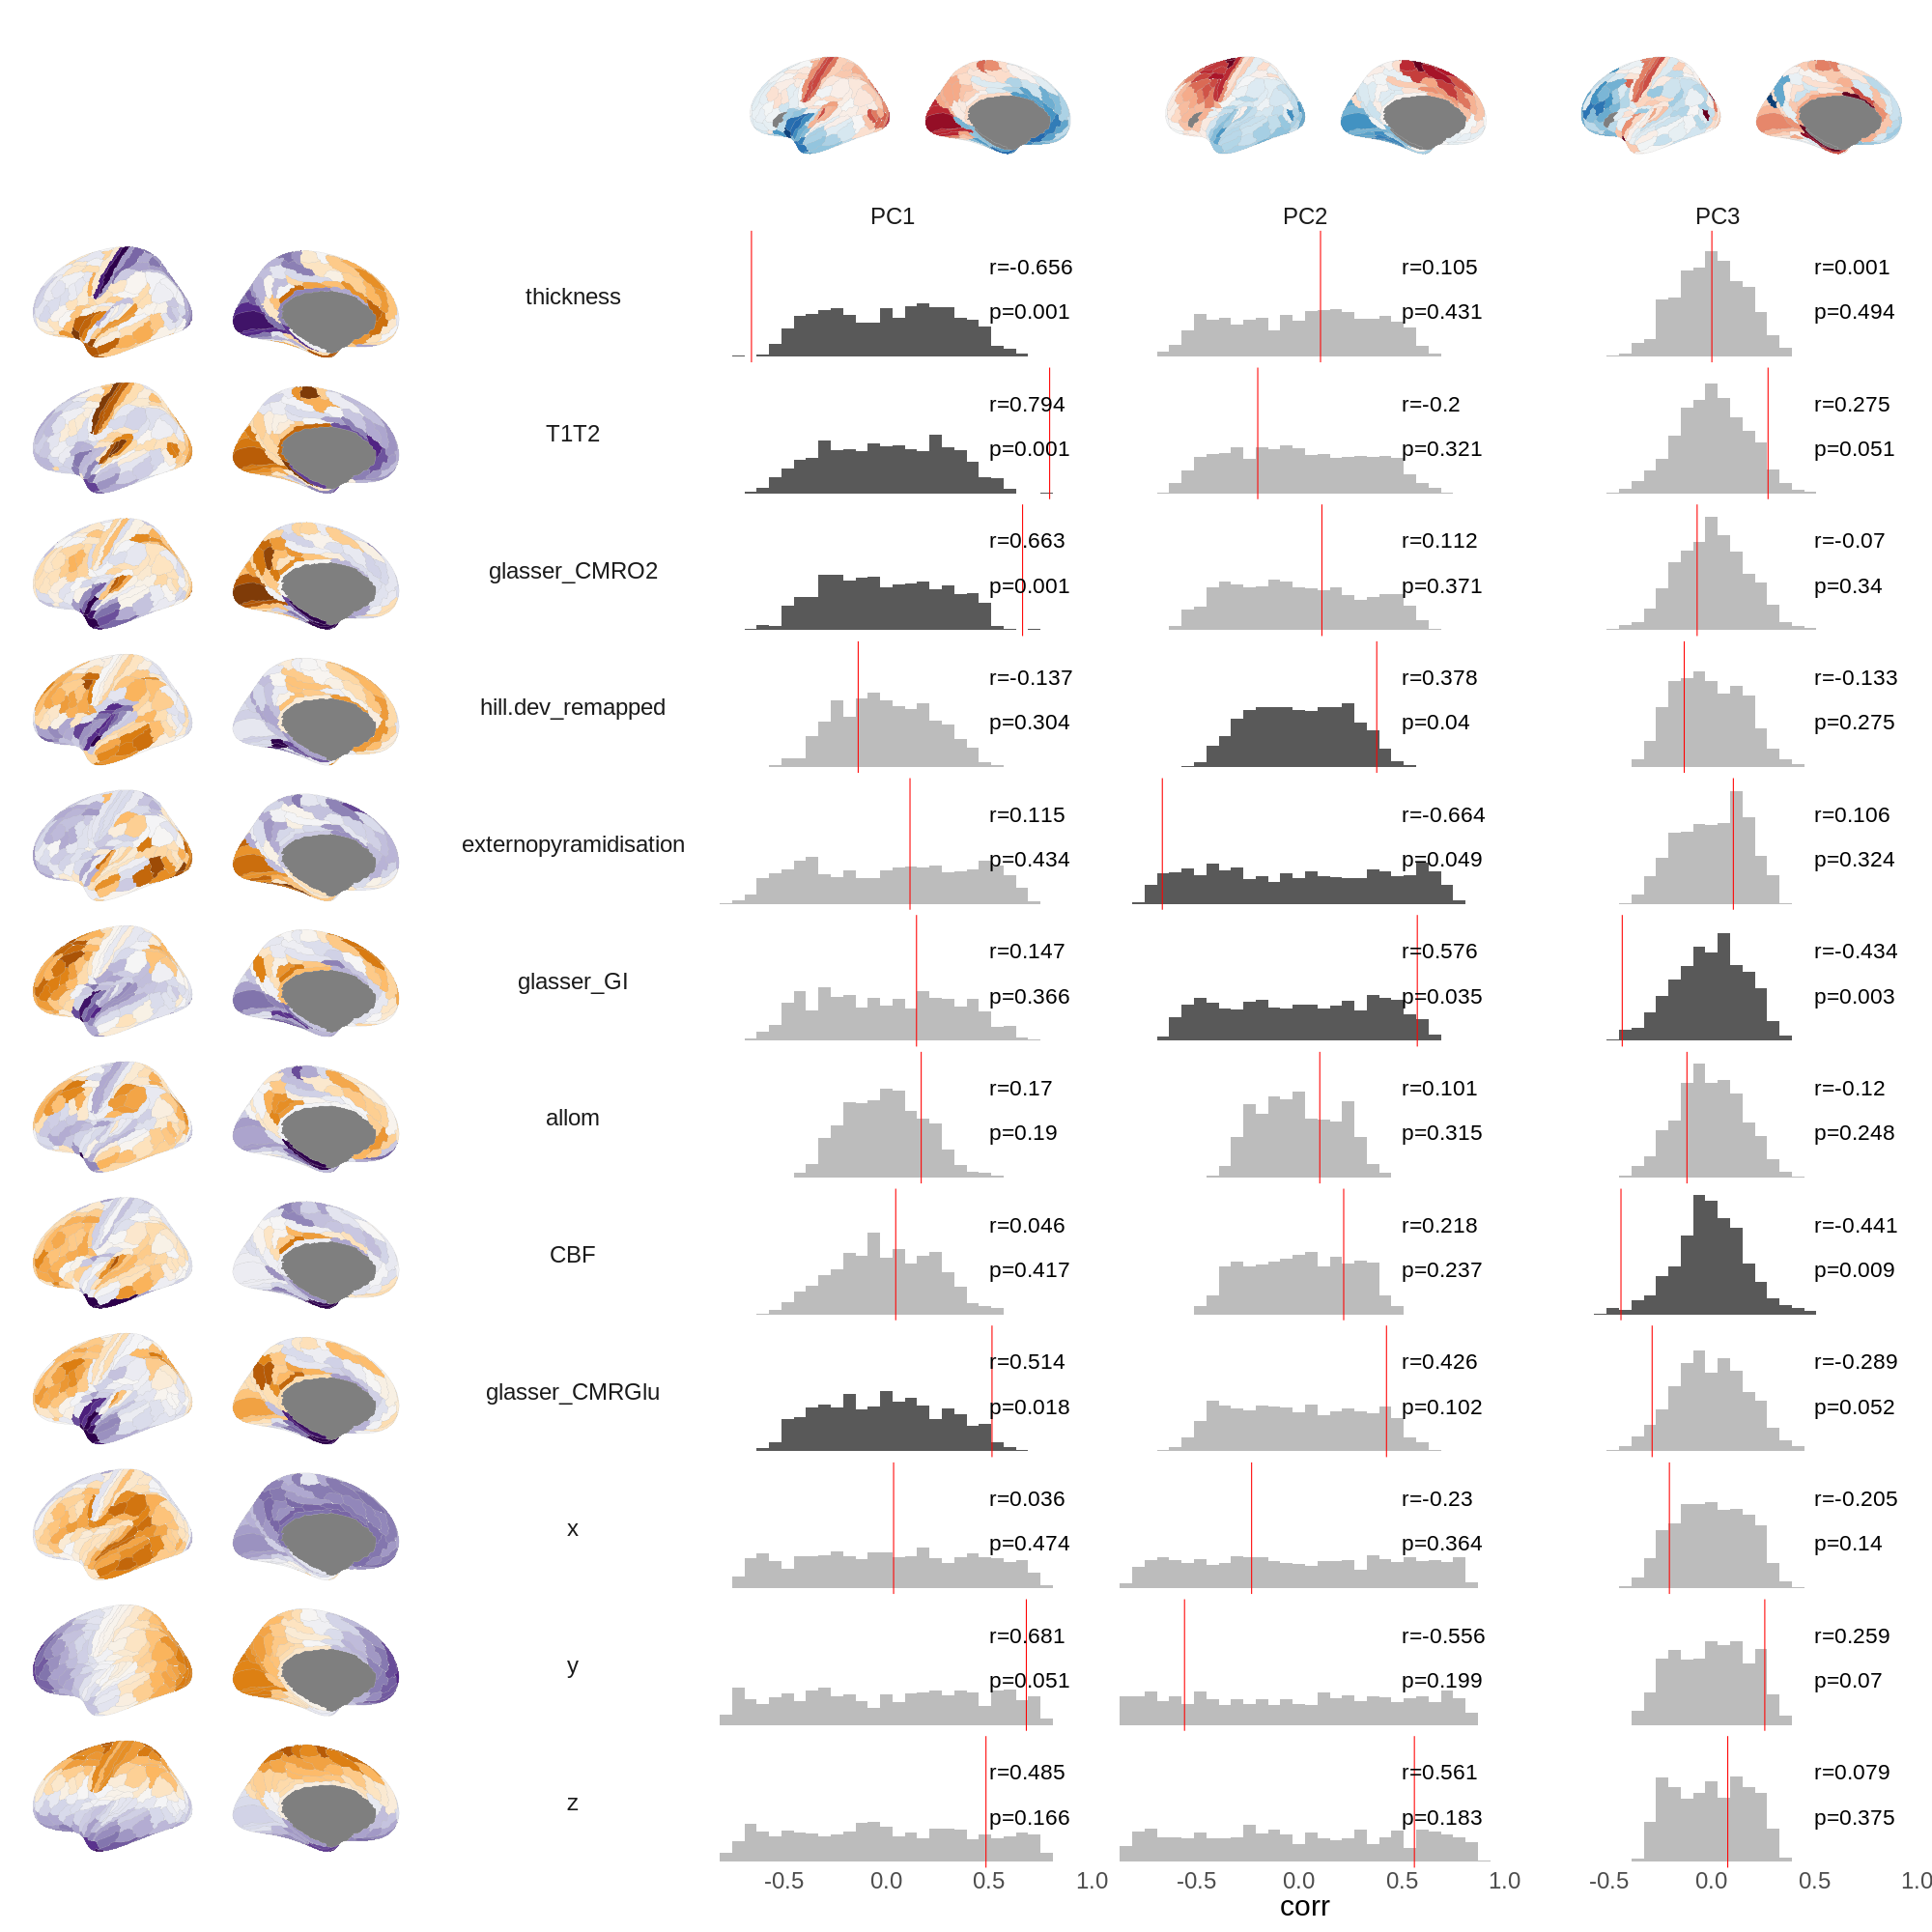

In [360]:
%%R -i corrs -i null_corrs -i null_p -i scores_plot -i maps_order -w 2000 -h 2000
source("../code/plot_maps.R")
g1 <- plot_spin_corrs(corrs, null_corrs, null_p)
g2 <- plot_hcp_wide(scores_plot) + guides(fill='none')
g3 <- plot_maps(maps_order, colors=rev(brewer.puor(100)), ncol=1) + theme(strip.text.x=element_blank()) + guides(fill='none')

(
    ((plot_spacer() | g2) + plot_layout(widths=c(3,5))) / 
    ((g3 | g1) + plot_layout(widths=c(1,3)))
) + plot_layout(heights=c(1,12))

If using all maps

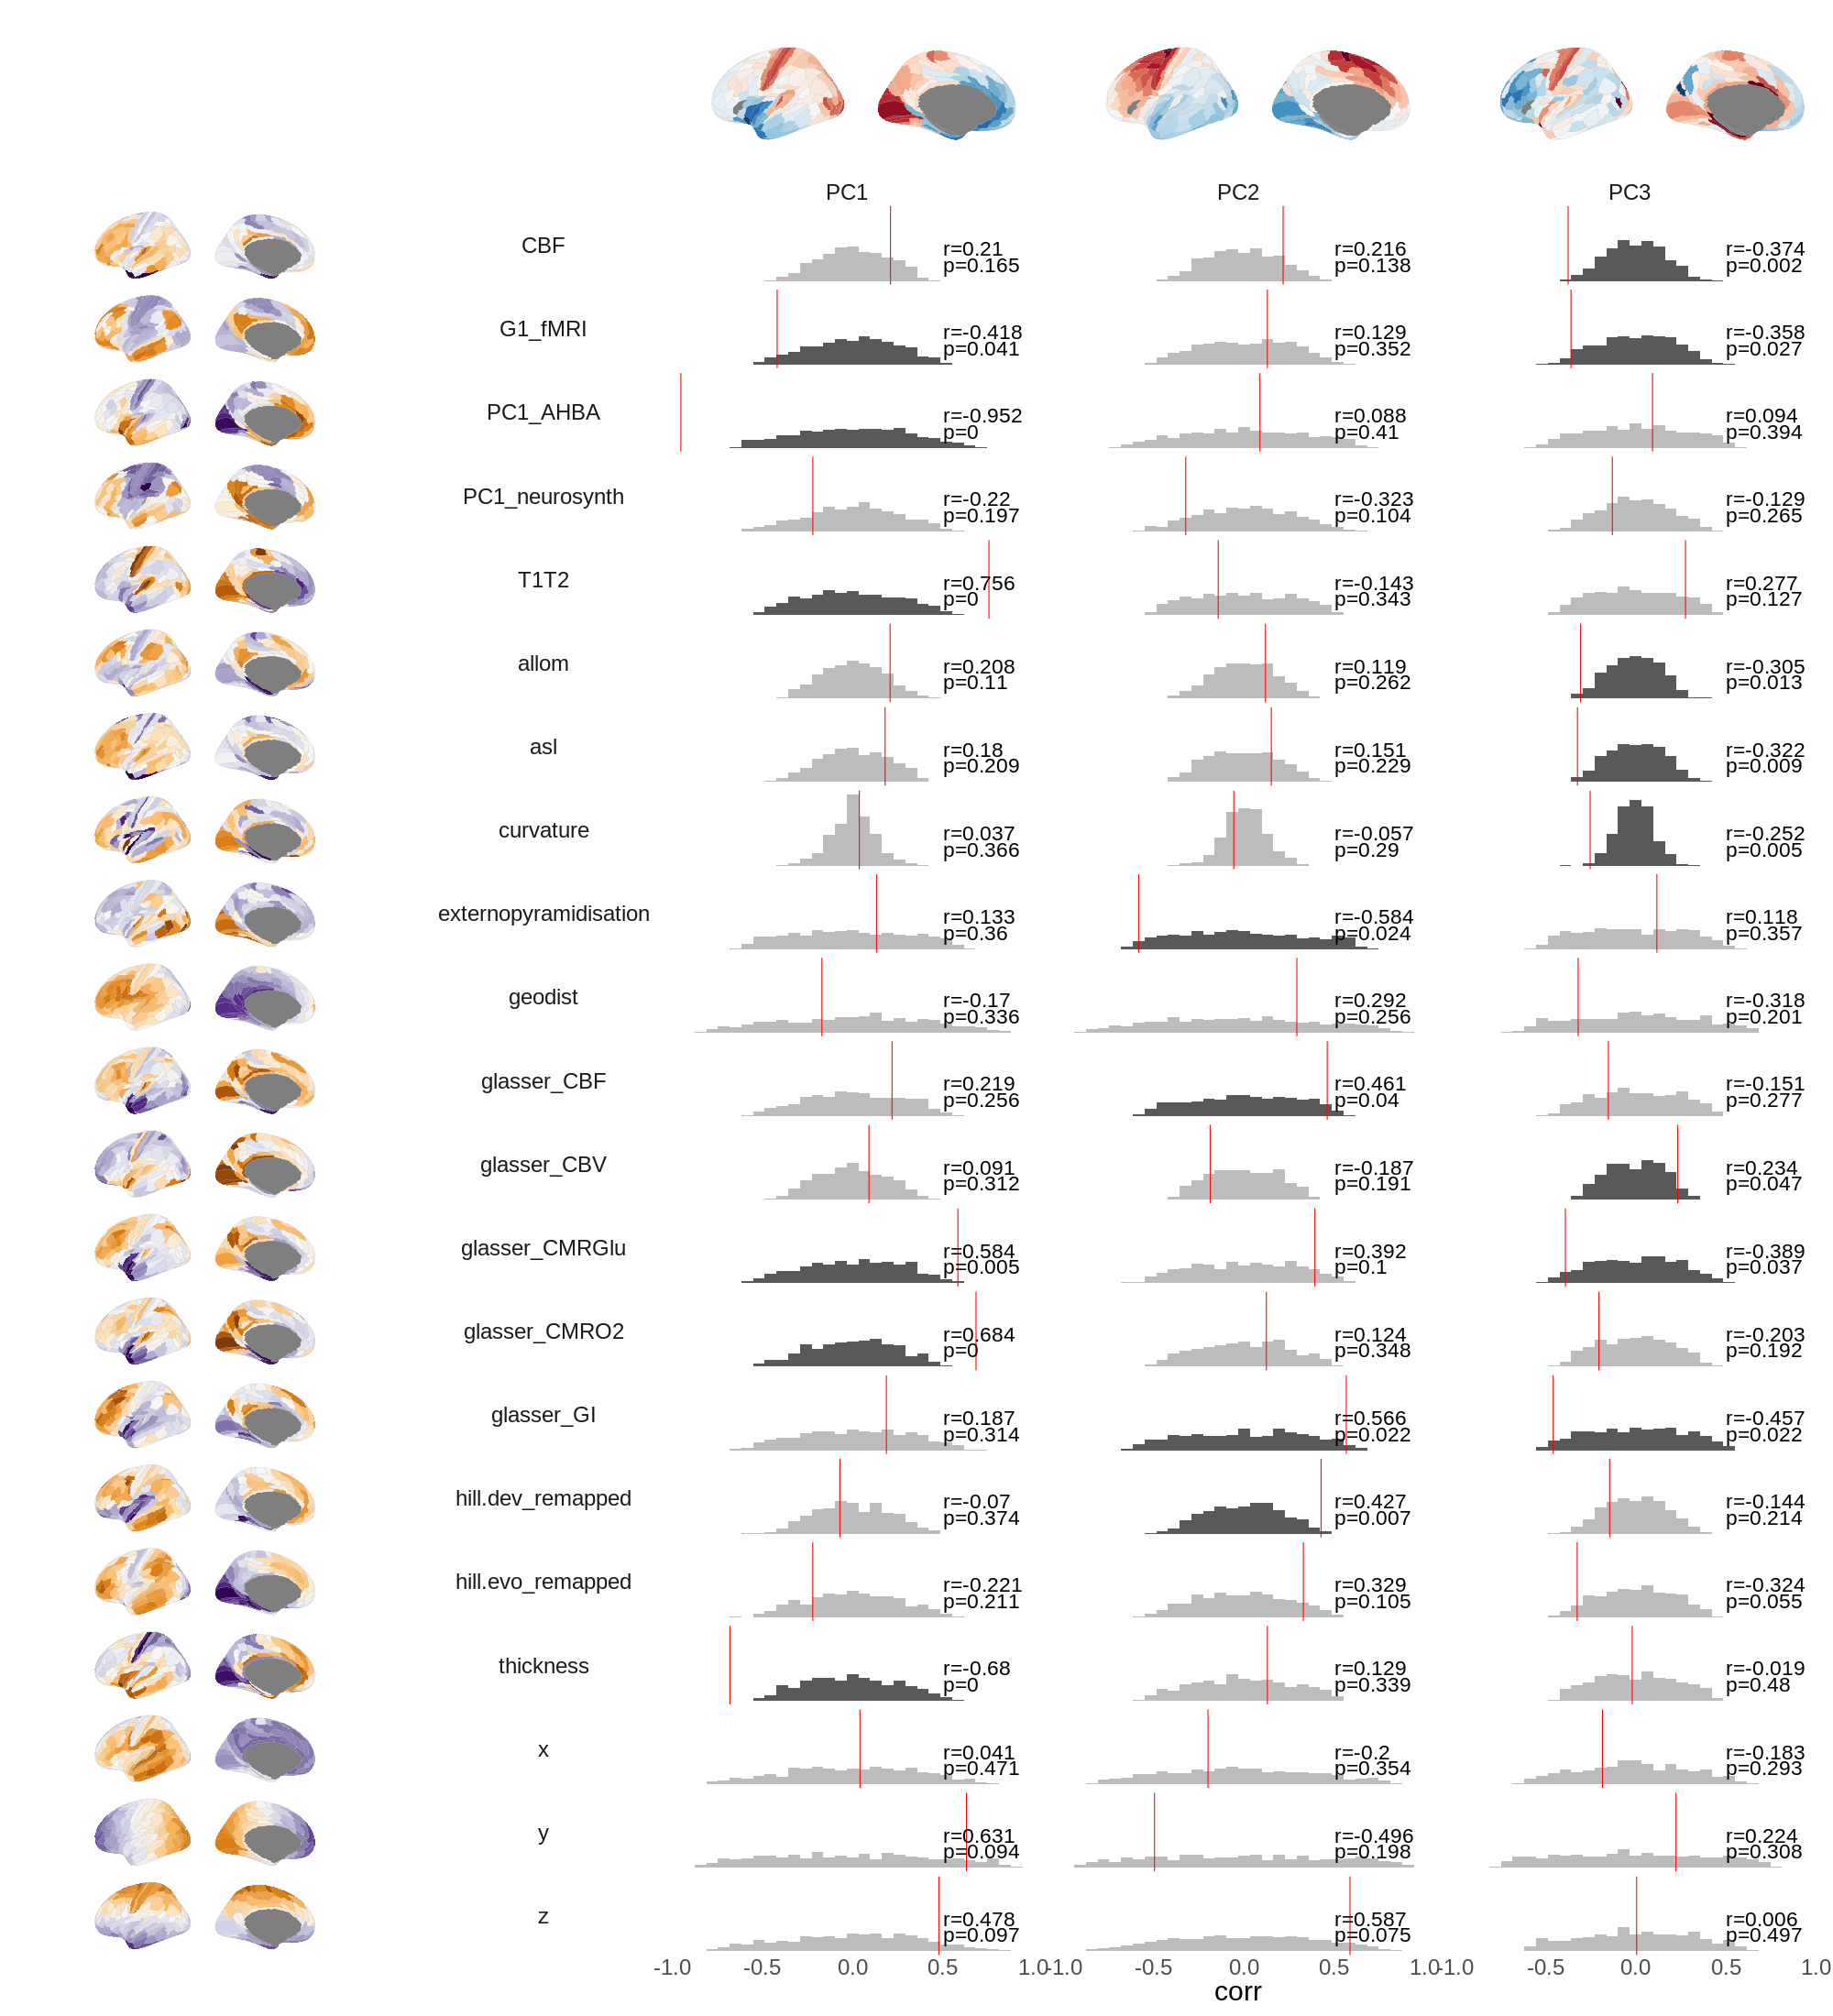

In [223]:
%%R -i corrs -i null_corrs -i null_p -i null_sig -i scores_plot -i maps_order -w 2000 -h 2200
source("../code/plot_maps.R")
g1 <- plot_spin_corrs(corrs, null_corrs, null_p, null_sig)
g2 <- plot_hcp_wide(scores_plot) + guides(fill='none')
g3 <- plot_maps(maps_order, colors=rev(brewer.puor(100)), ncol=1) + theme(strip.text.x=element_blank()) + guides(fill='none')

(
    ((plot_spacer() | g2) + plot_layout(widths=c(3,5))) / 
    ((g3 | g1) + plot_layout(widths=c(1,3)))
) + plot_layout(heights=c(1,15))

Plot spins

In [496]:
null_corrs = null_corrs_dict['spin_maps_pe']
null_maps = spin_maps
# null_corrs = null_corrs_dict['sim_maps_pe']
# null_maps = sim_maps_1000

In [497]:
percentiles = [0,1,5,95,99,100]
pc = 'PC2'
m = 'hill.dev_remapped'
map_ix = list(maps.columns).index(m)

In [498]:
pc_corrs = (null_corrs
            .set_index('map').loc[m]
            .loc[:, pc]
           )
pcen = np.percentile(pc_corrs, q=percentiles)
null_ixs = [abs(pc_corrs - p).argmin() for p in pcen]
null_ixs

[78, 209, 815, 263, 214, 877]

In [499]:
p_c_pairs = zip(percentiles, pc_corrs[null_ixs])
cols = [str(p)+"th, r="+str(round(c,2)) for (p,c) in p_c_pairs]

nulls_to_plot = (
    pd.DataFrame(null_maps[:,map_ix, null_ixs], 
                 index=list(range(1,181)), 
                 columns=cols
                )
    .join(get_labels_hcp())
    .melt(id_vars='label', var_name='version', value_name='score')
    # .assign(version = lambda x: x['version'].astype('str') + 'th')
    # .assign(version = lambda x: 'corr = ' + x['version'].astype('str'))
    .fillna(0)
)

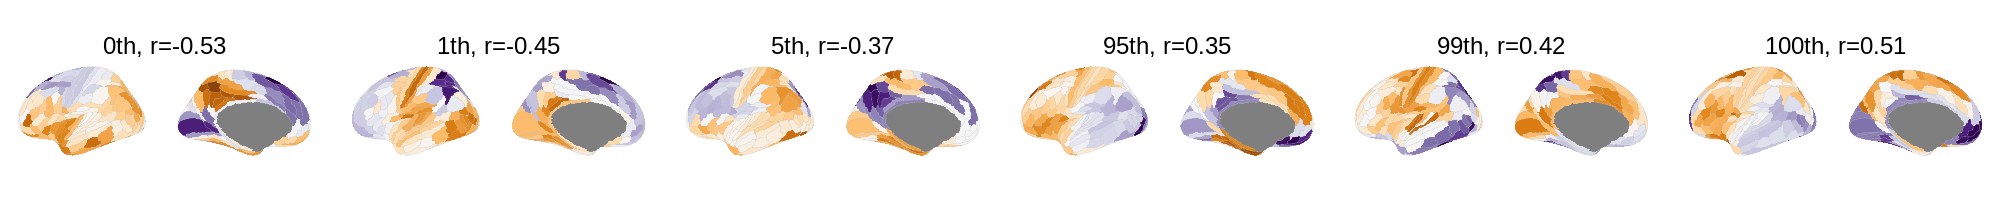

In [500]:
%%R -i nulls_to_plot -w 2000 -h 200
df <- nulls_to_plot %>% 
        mutate(region = recode(label,'7Pl'='7PL')) %>% select(-label) %>%
        mutate_at(vars(version), ~ factor(., levels=unique(.))) %>% 
        group_by(version)

    m <- pmax(
        df %>% .$score %>% quantile(.99) %>% abs,
        df %>% .$score %>% quantile(.01) %>% abs
    )

    glasser$data <- glasser$data %>% filter(hemi=='left')
    
    ggplot(df) + 
    geom_brain(
        atlas=glasser,
        mapping=aes(fill=score, geometry=geometry, hemi=hemi, side=side, type=type),
        colour='grey', size=.1,
        show.legend=T
        ) +
    theme_void() + 
    facet_wrap(~version, ncol=8) +
    theme(legend.position='bottom',
          strip.text.x=element_text(vjust=1),
          strip.text.y.left = element_text(angle = 0),
          plot.title=element_text(hjust=0.5)) +
    scale_fill_gradientn(colors=rev(brewer.puor(100)), 
                         limits=c(-m,m), oob=squish, breaks=c(-m,0,m), 
                         labels=c(round(-m,2),0,round(m,2)), name=''
                        ) +
    guides(fill='none') +
    coord_sf(clip='off') + xlab("") + ylab("") +
    theme(text=element_text(size=30))